# Plotting Notebook
This notebook displays and manipulates the histograms produced by `make_plots.py`. <br>
Please use this is a guide to the type plots that you can create, as examples of the `hist`, `mplhep`, and other packages, as well as the use of the various functions that we have written in `plot_utils.py`. <br>
Use the the Table of Contents in Jupyter to view the different sections of the notebook to help navigating it.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os, sys, glob
from rich.pretty import pprint
from rich.console import Console
from rich.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import json
import scipy
%aimport plot_utils
%aimport plot_utils_extras
%aimport fill_utils

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'
plt.style.use(hep.style.CMS)

In [4]:
print("The following output directories are available:")
!ls | grep output_cutflow

The following output directories are available:
CR_cb_34mu_output_cutflow
CR_cb_combine_output_cutflow
CR_cb_output_cutflow
CR_cb_postDYstudy_output_cutflow
CR_light_postDYstudy_output_cutflow
CR_prompt_34mu_leading_output_cutflow
CR_prompt_34mu_output_cutflow
CR_prompt_combine_output_cutflow
CR_prompt_dimuon_output_cutflow
CR_prompt_dystudy_output_cutflow
CR_prompt_leading_output_cutflow
CR_prompt_output_cutflow
CR_prompt_postDYstudy_output_cutflow
DYstudy_2_output_cutflow
DYstudy_3_output_cutflow
DYstudy_4_output_cutflow
DYstudy_5_output_cutflow
DYstudy_output_cutflow
DYstudy_trigger_match_double_output_cutflow
DYstudy_trigger_match_triple_output_cutflow
DYstudy_trigger_one_path_output_cutflow
nbjet_comparison_output_cutflow
SR_combine_output_cutflow
SR_postDYstudy_output_cutflow
temp_output_cutflow


In [5]:
hep.__version__

'0.3.12'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [6]:
# parameters
output_label = './output_plots/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [7]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = './SR_postDYstudy_output_cutflow/'
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [
    f for f in infile_names if ("SUEP" in f) and ("cutflow.pkl" in f)
]
offline_files_normalized = [
    f for f in infile_names if ("normalized.pkl" in f)
]
offline_files_other = [
    f for f in infile_names if ("pythia8" in f) and ("cutflow.pkl" in f)
]
offline_files = offline_files_normalized + offline_files_other
pprint(offline_files)

other_bkg_names = {
    "DY0JetsToLL": "DY0JetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYJetsToLL_NLO": "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYLowMass_NLO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                     "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "DYLowMass_LO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8+"
                    "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM",
    "TTJets": "TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ttZJets": "ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8+"
               "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "WWZ_4F": "WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "ZZTo4L": "ZZTo4L_TuneCP5_13TeV_powheg_pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ZZZ": "ZZZ_TuneCP5_13TeV-amcatnlo-pythia8+"
           "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "WJets_inclusive": "WJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                 "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM",
    "ST_tW": "ST_tW_Dilept_5f_DR_TuneCP5_13TeV-amcatnlo-pythia8+"
             "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM"
}

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = plot_utils.loader(offline_files_SUEP, year=2018)
plots_2018 = plot_utils.loader(offline_files, year=2018)

# put everything in one dictionary, apply lumi for SUEPs
plots = {}
for key in plots_SUEP_2018.keys(): 
    plots[key+"_2018"] = fill_utils.apply_normalization(
        plots_SUEP_2018[key], 
        fill_utils.getXSection(key+'+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True)
    )
for key in plots_2018.keys():
    is_binned = False
    binned_samples = [
        "QCD_Pt",
        "WJetsToLNu_HT",
        "WZTo",
        "WZ_all",
        "WWTo",
        "WW_all",
        "ST_t-channel",
        "JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8",
        "DYNJetsToLL",
    ]
    for binned_sample in binned_samples:
        if binned_sample in key:
            is_binned = True
    if is_binned and ('normalized' not in key) and ('cutflow' in key):
        continue
    if is_binned or ('bkg' in key):
        plots[key+"_2018"] = plots_2018[key]
    else:
        plots[key+"_2018"] = fill_utils.apply_normalization(
            plots_2018[key], 
            fill_utils.getXSection(other_bkg_names[key], '2018', SUEP=False)
        )

# Combine DYNJetsToLL with DYLowMass_LO
dy_lo_all = {}
for plt_i in plots["DYLowMass_LO_2018"].keys():
    dy_lo_all[plt_i] = (
        plots["DYLowMass_LO_2018"][plt_i]
        + plots["DYNJetsToLL_2018"][plt_i]
        + plots["DY0JetsToLL_2018"][plt_i]
    )
plots["DY_LO_all_2018"] = dy_lo_all

# Combine DYJetsToLL_NLO with DYLowMass_NLO
dy_nlo_all = {}
for plt_i in plots["DYLowMass_NLO_2018"].keys():
    dy_nlo_all[plt_i] = (
        plots["DYLowMass_NLO_2018"][plt_i] + plots["DYJetsToLL_NLO_2018"][plt_i]
    )
plots["DY_NLO_all_2018"] = dy_nlo_all

# Combine ZZZ with WWZ
vvv_combined = {}
for plt_i in plots['WWZ_4F_2018'].keys():
    vvv_combined[plt_i] = plots['WWZ_4F_2018'][plt_i] + plots['ZZZ_2018'][plt_i]
plots['VVV_2018'] = vvv_combined

# Combine ZZ, WZ, and WW
vv_combined = {}
for plt_i in plots['WZ_all_2018'].keys():
    vv_combined[plt_i] = plots['WW_all_2018'][plt_i] + plots['WZ_all_2018'][plt_i] + plots['ZZTo4L_2018'][plt_i]
plots['VV_2018'] = vv_combined

# Combine ST
st_combined = {}
for plt_i in plots['ST_t-channel_2018'].keys():
    st_combined[plt_i] = plots['ST_t-channel_2018'][plt_i] + plots['ST_tW_2018'][plt_i]
plots['ST_2018'] = st_combined

# Combine WJetsHT and WJets_inclusive
wjets_combined = {}
for plt_i in plots['WJetsToLNu_HT_2018'].keys():
    wjets_combined[plt_i] = plots['WJetsToLNu_HT_2018'][plt_i] + plots['WJets_inclusive_2018'][plt_i]
plots['WJets_all_2018'] = wjets_combined

# Normalize QCD MuEnriched if it exists
if "QCD_Pt_MuEnriched_2018" in plots.keys():
    for plot in plots["QCD_Pt_MuEnriched_2018"].keys():
        plots["QCD_Pt_MuEnriched_2018"][plot] = plots["QCD_Pt_MuEnriched_2018"][plot] * 0.7

[
│   './SR_postDYstudy_output_cutflow/DY1JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/DY2JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/DY3JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/DY4JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized.pkl',
│   './SR_postDYstudy_output_cutflow/QCD_Pt_1800to2400_TuneCP5_13TeV_py

These are all the samples loaded.

In [8]:
keys = list(plots.keys())
pprint(keys)

[
│   'SUEP-m125-darkPho_2018',
│   'SUEP-m125-darkPhoHad_2018',
│   'SUEP-m400-darkPho_2018',
│   'SUEP-m400-darkPhoHad_2018',
│   'SUEP-m750-darkPho_2018',
│   'SUEP-m750-darkPhoHad_2018',
│   'SUEP-m1000-darkPho_2018',
│   'SUEP-m1000-darkPhoHad_2018',
│   'DY1JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'bkg_2018',
│   'DYNJetsToLL_2018',
│   'DY2JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'DY3JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'DY4JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_MuEnriched_2018',
│   'QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_2018',
│   'QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
│   'QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2

In [9]:
for key in plots['QCD_Pt_2018'].keys():
    pprint(f"{key = }")

"key = 'cutflow'"

In [10]:
plots['QCD_Pt_2018']['cutflow']

Hist(StrCategory(['all', 'trigger', 'nMuon>4', 'nMuon>=6', 'lmu_inter_iso_16>1', 'muon_pt_mean<10'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=7.46688e+13, variance=2.31996e+20)

## 1D Plots
Plot some of the 1D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_labels`: _list of str_, which plots to show.<br>
`samples`: _list of str_, which samples to include in the plot.

### Cutflows
Cutflow plots. First one is all non QCD bkgs not stacked

DYLowMass_LO_2018: 945713188.86000 ± 94954.74593
DYLowMass_LO_2018: 2774.38607 ± 162.63739
DYLowMass_LO_2018: 0.00000 ± 0.00000
DYLowMass_NLO_2018: 1223864126.76000 ± 669.79134
DYLowMass_NLO_2018: 3320.21749 ± 334.06589
DYLowMass_NLO_2018: 0.00000 ± 0.00000
DYNJetsToLL_2018: 80354516.00198 ± 13773.87353
DYNJetsToLL_2018: 6209.64116 ± 94.37670
DYNJetsToLL_2018: 3.84704 ± 1.23515


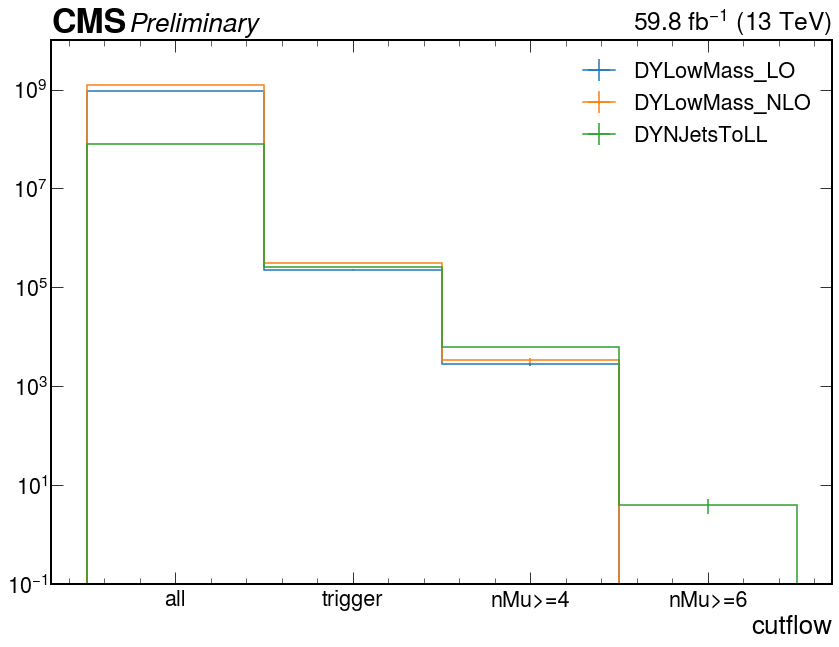

In [23]:
plot_labels = ['cutflow']
year='2018'
decay='darkPho'

n = 6 # 0 or 6
cols_to_show = [1] + list(range(n+2,n+6))

# basic columns
cols_to_show = [0, 1, 2, 8]

# for avpt
#cols_to_show = [1, 6, 7, 12, 13]

samples_bkg = [
    #'QCD_Pt_2018',
    #'QCD_Pt_MuEnriched_2018',
    'DYLowMass_LO_2018',
    'DYLowMass_NLO_2018',
    'DYNJetsToLL_2018',
    #'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
show_all_events = True
verbose = True
plot_signal = False

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(14, 10))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h_temp = plots[sample][plot_label]
        if verbose:
            print(f"{sample}: {h_temp[0].value:.5f} ± {math.sqrt(h_temp[0].variance):.5f}")
            print(f"{sample}: {h_temp[2].value:.5f} ± {math.sqrt(h_temp[2].variance):.5f}")
            print(f"{sample}: {h_temp[8].value:.5f} ± {math.sqrt(h_temp[8].variance):.5f}")
        if show_all_events:
            h = h_temp[cols_to_show]
        else:
            h = h_temp[cols_to_show]
        if density:
            h = h/h.sum().value
        h_bkg.append(h)
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        #color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=False,
        histtype='step',
    )

    for sample in samples_signal:
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label]
        if verbose:
            print(sample, h_temp[0])
            print(sample, h_temp[3])
        if show_all_events:
            h = h_temp[cols_to_show]
        else:
            h = h_temp[cols_to_show]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            #color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    plt.ylim(1e-2, 1e9)
    if show_all_events:
        plt.ylim(1e-1, 1e10)
    # plt.setp(ax.get_xticklabels(), rotation=350)
    plt.xlabel('cutflow')
    plt.legend(ncol=1)
    plt.yscale("log")
    plt.show()

Hist(StrCategory(['trigger', 'nMu>=4', 'nMu>=4 & I16>1', 'nMu>=4 & ptMu<10'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=41963.6, variance=46329.8)

Plot only the signal

SUEP-m125-darkPhoHad_2018 WeightedSum(value=2.70375e+06, variance=7.53638e+08)
SUEP-m125-darkPhoHad_2018 WeightedSum(value=7247.59, variance=2.02029e+06)
SUEP-m400-darkPhoHad_2018 WeightedSum(value=189023, variance=3.57297e+06)
SUEP-m400-darkPhoHad_2018 WeightedSum(value=5613.68, variance=106106)
SUEP-m750-darkPhoHad_2018 WeightedSum(value=29723.3, variance=88358.2)
SUEP-m750-darkPhoHad_2018 WeightedSum(value=5888.47, variance=17503.3)
SUEP-m1000-darkPhoHad_2018 WeightedSum(value=11036.3, variance=12183.6)
SUEP-m1000-darkPhoHad_2018 WeightedSum(value=5071.89, variance=5597.8)


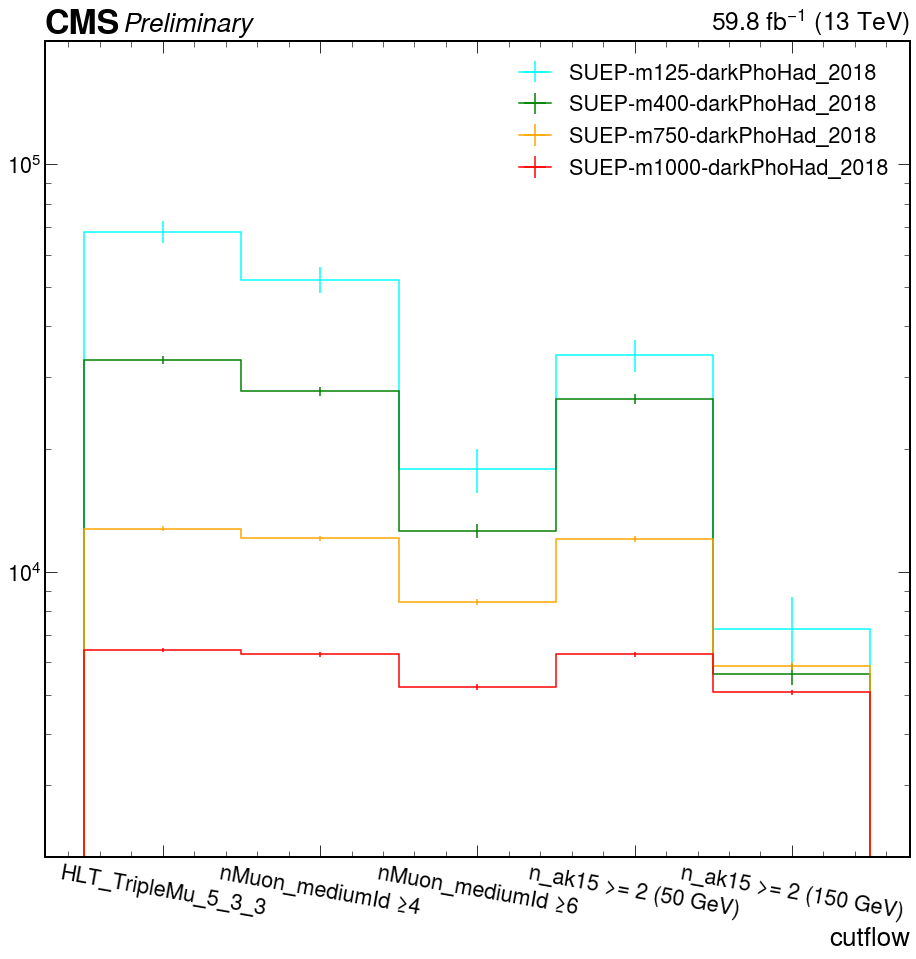

In [24]:
plot_labels = ['cutflow']
year='2018'
decay='darkPhoHad'

samples_signal = [
    f'SUEP-m125-{decay}_2018',
    f'SUEP-m400-{decay}_2018',
    f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
show_all_events = False
verbose = True

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(15.5, 15))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))

    for sample in samples_signal:
        h_temp = plots[sample][plot_label]
        if verbose:
            print(sample, h_temp[0])
            print(sample, h_temp[5])
        if show_all_events:
            h = h_temp[]
        else:
            h = hist.Hist.new.StrCategory(
                [
                    "HLT_TripleMu_5_3_3",
                    "nMuon_mediumId ≥4",
                    "nMuon_mediumId ≥6",
                    "n_ak15 >= 2 (50 GeV)",
                    "n_ak15 >= 2 (150 GeV)",
                ],
                name="cutflow",
                label="cutflow",
            ).Weight()
            h[0] = h_temp[1]
            h[1] = h_temp[2]
            h[2] = h_temp[3]
            h[3] = h_temp[4]
            h[4] = h_temp[5]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    plt.ylim(3e3, 2e6)
    if decay == 'darkPhoHad':
        plt.ylim(2e3, 2e5)
    if show_all_events:
        plt.ylim(1e0, 1e14)
    plt.setp(ax.get_xticklabels(), rotation=350)
    plt.xlabel('cutflow')
    plt.legend()
    plt.yscale("log")
    plt.show()

And all the non QCD backgrounds as a stack plot

<Figure size 720x720 with 0 Axes>

VVV_2018 WeightedSum(value=0.00285735, variance=1.2784e-06)
VVV_2018 WeightedSum(value=0, variance=0)
ttZJets_2018 WeightedSum(value=0.0485594, variance=4.3667e-05)
ttZJets_2018 WeightedSum(value=0.00449624, variance=4.04324e-06)
WJets_all_2018 WeightedSum(value=0, variance=0)
WJets_all_2018 WeightedSum(value=0, variance=0)
ST_2018 WeightedSum(value=0.0339879, variance=0.0011362)
ST_2018 WeightedSum(value=0.0339879, variance=0.0011362)
VV_2018 WeightedSum(value=0.190901, variance=0.0173539)
VV_2018 WeightedSum(value=0.00147199, variance=1.08338e-06)
TTJets_2018 WeightedSum(value=2.04218, variance=3.16957)
TTJets_2018 WeightedSum(value=0.81687, variance=0.667277)
DY_NLO_all_2018 WeightedSum(value=0, variance=0)
DY_NLO_all_2018 WeightedSum(value=0, variance=0)
QCD_Pt_MuEnriched_2018 WeightedSum(value=27.3626, variance=471.182)
QCD_Pt_MuEnriched_2018 WeightedSum(value=26.471, variance=470.856)
SUEP-m125-darkPho_2018 WeightedSum(value=201473, variance=5.01131e+07)
SUEP-m125-darkPho_2018 We

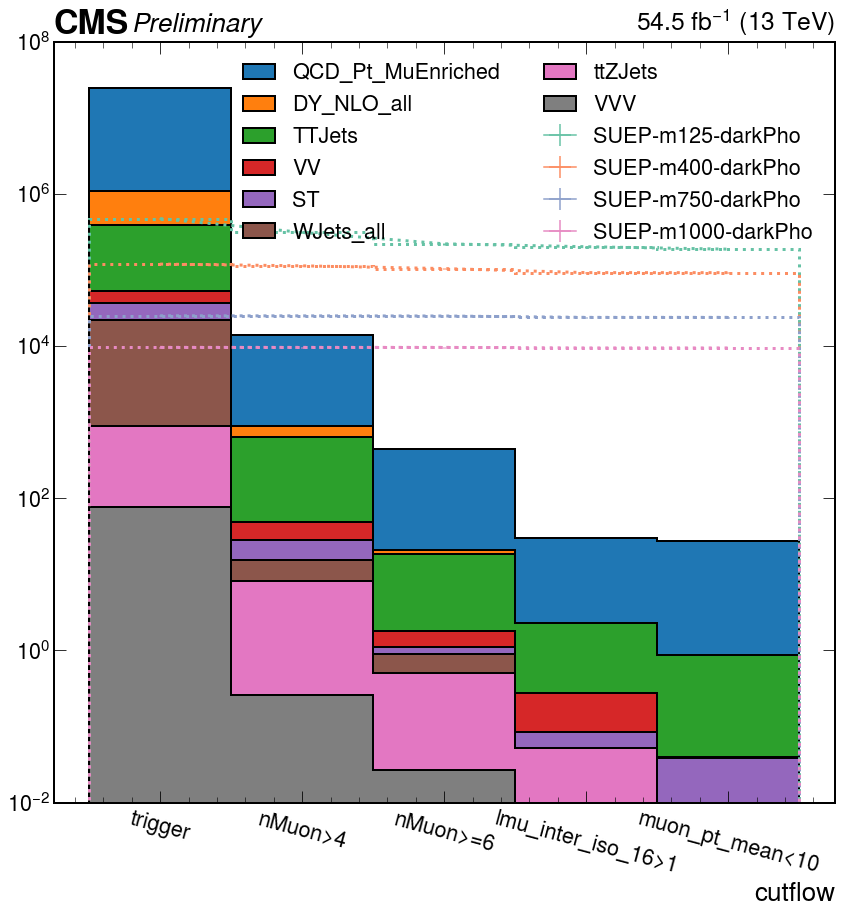

In [14]:
plot_labels = ['cutflow']
year='2018'
decay='darkPho'

samples_bkg = [
    'VVV_2018',
    'ttZJets_2018',
    #'ZZTo4L_2018',
    #'WJetsToLNu_HT_2018',
    #'WJets_inclusive_2018',
    'WJets_all_2018',
    #'WW_all_2018', 
    #'WZ_all_2018', 
    #'ST_tW_2018',
    #'ST_t-channel_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    #'DYLowMass_LO_2018',
    #'DYLowMass_NLO_2018',
    #'DYJetsToLL_NLO_2018',
    #'DY0JetsToLL_2018',
    #'DYNJetsToLL_2018',
    'QCD_Pt_MuEnriched_2018',
    #'QCD_Pt_2018',
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    f'SUEP-m400-{decay}_2018',
    f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

cols_to_show = [1, 2, 3, 4, 5]

density = False
show_all_events = False
plot_signal = True
verbose = True

for plot_label in plot_labels:    
    fig, ax = plt.subplots(figsize=(14, 14))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h_temp = plots[sample][plot_label]
        if verbose:
            print(sample, h_temp[-2])
            print(sample, h_temp[-1])
        if show_all_events:
            h = h_temp[cols_to_show]
        else:
            h = h_temp[cols_to_show]
        if density: h = h/h.sum().value
        h_bkg.append(h)
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        #color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=True,
        histtype='fill',
        ec="black",
        lw=2,
    )

    for i, sample in enumerate(samples_signal): 
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label]
        if verbose:
            print(sample, h_temp[-2])
            print(sample, h_temp[-1])
        if show_all_events:
            h = h_temp[cols_to_show]
        else:
            h = h_temp[cols_to_show]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample[:-5], 
            lw=3,
            color=plt.cm.Set2(i), #plot_utils.default_colors[sample],
            ls=':',
        )

    # tweak these by hand, as needed
    plt.ylim(1e-2, 1e8)
    if show_all_events:
        plt.ylim(1e-1, 1e14)
    plt.setp(ax.get_xticklabels(), rotation=345)
    plt.xlabel('cutflow')
    plt.legend(ncol=2)
    plt.yscale("log")
    # plt.set_cmap('tab10')
    plt.show()

In [ ]:
for i in range(4):
    print(plt.cm.tab10(i))

And QCD+TTJets vs signal...

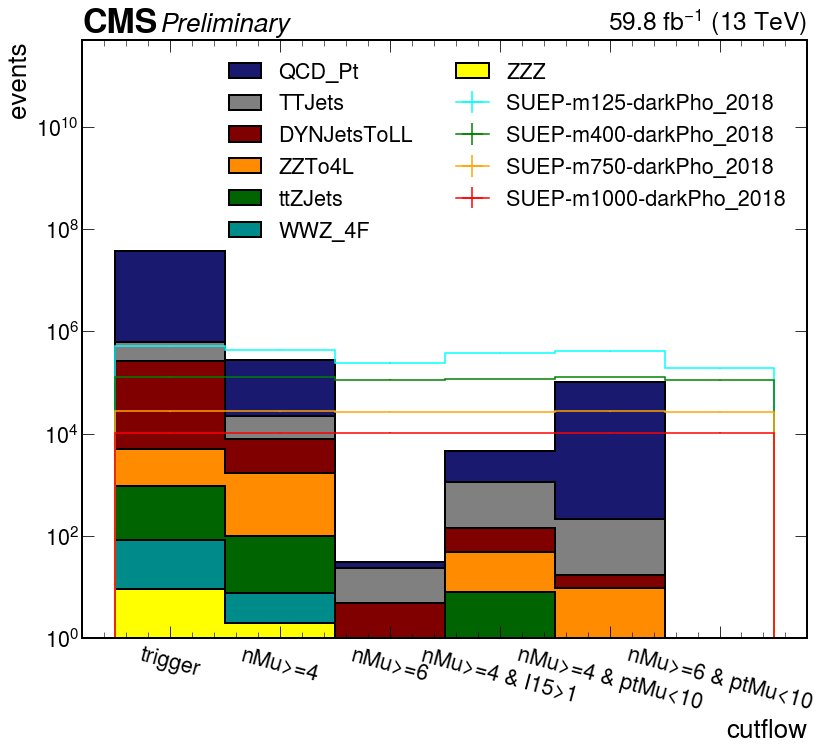

In [25]:
plot_labels = ['cutflow']
year='2018'
decay='darkPho'

samples_bkg = [
    'ZZZ_2018',
    'WWZ_4F_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'QCD_Pt_2018',
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    f'SUEP-m400-{decay}_2018',
    f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
show_all_events = False
plot_signal = True
verbose = False

for plot_label in plot_labels:    
    fig, ax = plt.subplots(figsize=(13, 11))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h = plots[sample][plot_label][:7]
        if verbose:
            print(sample, h[0])
            print(sample, h[3])
        if not show_all_events:
            h = h[1:]
        if density: h = h/h.sum().value
        h_bkg.append(h)
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=True,
        histtype='fill',
        ec="black",
        lw=2,
    )

    for sample in samples_signal: 
        if not plot_signal:
            continue
        h = plots[sample][plot_label][:7]
        if verbose:
            print(sample, h[0])
            print(sample, h[3])
        if not show_all_events:
            h = h[1:]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    plt.ylim(1e-2, 2e9)
    if plot_signal:
        plt.ylim(1e0, 5e11)
    if show_all_events:
        plt.ylim(1e0, 1e14)
    plt.setp(ax.get_xticklabels(), rotation=345)
    plt.xlabel('cutflow')
    plt.ylabel('events')
    plt.legend(ncol=2)
    plt.yscale("log")
    plt.show()

In [44]:
math.sqrt(28980.5)

170.2366000600341

In [26]:
cutflow_table = pd.DataFrame(
    [],
    columns=["sample"] + [c for c in h.axes[0]]
)

In [30]:
year='2018'
decay='darkPhoHad'

samples = [
    #'QCD_Pt_2018',
    f'SUEP-m125-{decay}_2018',
    f'SUEP-m400-{decay}_2018',
    f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    h_temp = plots[sample][plot_label]
    cutflow_table.append([sample] + h.to_numpy()[0].tolist())

In [31]:
for sample in samples:
    h_temp = plots[sample][plot_label]
    print([sample] + h_temp.to_numpy()[0].tolist())

['SUEP-m125-darkPhoHad_2018', 2703746.86680717, 68283.44366905538, 52118.531445006236, 17837.43288844551]
['SUEP-m400-darkPhoHad_2018', 189023.00904806747, 33154.46118692999, 27710.16439173227, 12588.672104022186]
['SUEP-m750-darkPhoHad_2018', 29723.269595333062, 12776.73336073047, 12081.269980249781, 8445.674503897422]
['SUEP-m1000-darkPhoHad_2018', 11036.311740954954, 6433.936547936915, 6283.887698295905, 5219.290061797345]


cutflow_table

In [32]:
for key in plots.keys():
    if 'QCD_Pt_' in key:
        print(key)

QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_2018
QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018
QCD_Pt_30

First is the summary:

In [43]:
# Initialize a table
table = Table(title="Cutflow")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

# Define samples
year='2018'
plot_label = 'cutflow'
samples = [
    'VVV_2018',
    'ttZJets_2018',
    #'ZZTo4L_2018',
    #'WJetsToLNu_HT_2018',
    #'WJets_inclusive_2018',
    'WJets_all_2018',
    #'WW_all_2018', 
    #'WZ_all_2018', 
    #'ST_tW_2018',
    #'ST_t-channel_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    #'DYLowMass_LO_2018',
    #'DYLowMass_NLO_2018',
    #'DYJetsToLL_NLO_2018',
    #'DY0JetsToLL_2018',
    #'DYNJetsToLL_2018',
    #'QCD_Pt_MuEnriched_2018',
    'QCD_Pt_2018',
]
samples = samples[::-1]
decays=['darkPho', 'darkPhoHad']
for decay in decays:
    samples += [
        f'SUEP-m125-{decay}_2018',
        f'SUEP-m400-{decay}_2018',
        f'SUEP-m750-{decay}_2018',
        f'SUEP-m1000-{decay}_2018',
    ]

# Set columns to display
n=7
cols_to_show = [0, 1, 2] #list(range(n,n+3))
for i in cols_to_show:
    col_name = plots[samples[0]][plot_label].axes[0].bin(i).replace('I15', 'I16')
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

#table.add_column("all", justify="center", style="magenta", no_wrap=True, width=22) # bin=0
#table.add_column("trigger", justify="center", style="green", no_wrap=True, width=22) # bin=1
#table.add_column("nMu≥4", justify="center", style="green", no_wrap=True, width=22) # bin=2
#table.add_column("nMu≥6", justify="center", style="green", no_wrap=True, width=22) # bin=3
#table.add_column("nMu≥4 & I15>1", justify="center", style="green", no_wrap=True, width=22) # bin=4
#table.add_column("nMu≥4 & ptMu<10GeV", justify="center", style="green", no_wrap=True, width=22) # bin=5
#table.add_column("nMu≥6 & ptMu<10GeV", justify="center", style="green", no_wrap=True, width=22) # bin=6
#table.add_column("nAK15>0 (30 GeV)", justify="center", style="green", no_wrap=True, width=22) # bin=7

h_total_bkg = None
for sample in samples:
    end_section=False
    if 'VVV' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    if 'SUEP' not in sample:
        if h_total_bkg is None:
            h_total_bkg = h_temp.copy()
        else:
            h_total_bkg += h_temp
    string = []
    estring = []
    for i in range(h_temp.size-1):
        s = f'{h_temp[i].value:0.1f}'
        es = f'{math.sqrt(h_temp[i].variance):0.1f}'
        if h_temp[i].value > 1000:
            s = f'{h_temp[i].value:0.1e}'
            es = f'{math.sqrt(h_temp[i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample.split("+")[0].replace('_TuneCP5_13TeV_pythia8','').replace('_2018',''), 
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show],
        end_section=end_section
    )
    if 'VVV' in sample:
        string = []
        estring = []
        for i in range(h_total_bkg.size-1):
            s = f'{h_total_bkg[i].value:0.1f}'
            es = f'{math.sqrt(h_total_bkg[i].variance):0.1f}'
            if h_total_bkg[i].value > 1000:
                s = f'{h_total_bkg[i].value:0.1e}'
                es = f'{math.sqrt(h_total_bkg[i].variance):0.1e}'
            string += [s]
            estring += [es]
        table.add_row(
            "Total background", 
             *[f'{string[i]} ± {estring[i]}' for i in cols_to_show],
            end_section=end_section
        )


console = Console()
console.print(table)

                                               Cutflow                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Sample         ┃          all           ┃        trigger         ┃        nMuon>4         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         QCD_Pt         │   7.5e+13 ± 1.5e+10    │   3.4e+07 ± 8.4e+06    │     470.2 ± 270.4      │
│       DY_NLO_all       │   1.4e+09 ± 6.4e+02    │   7.1e+05 ± 3.1e+03    │      264.3 ± 58.0      │
│         TTJets         │   4.5e+07 ± 5.8e+01    │   3.3e+05 ± 6.3e+02    │      582.4 ± 27.5      │
│           VV           │   5.1e+06 ± 1.4e+02    │   1.7e+04 ± 3.6e+01    │       21.1 ± 0.7       │
│           ST           │   1.1e+07 ± 7.5e+01    │   1.5e+04 ± 2.8e+01    │       12.7 ± 0.8       │
│       WJets_all        │   3.8e+09 ± 1.3e+04    │   2.1e+04 ± 1.7e+03    │       7.5 ± 1.3        │
│        ttZJets         │   2.9e+04 ± 5.1e+00    │      799.1 ± 0.8       │       7.9 ± 0.1        │
│          VVV           │   1.0e+04 ± 7.4e+00    │       76.3 ± 0.3       │       0.3 ± 0.0        │
├────────────────────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│    Total background    │   7.5e+13 ± 1.5e+10    │   3.5e+07 ± 8.4e+06    │   1.4e+03 ± 2.8e+02    │
├────────────────────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│   SUEP-m125-darkPho    │   2.5e+06 ± 2.5e+04    │   4.7e+05 ± 1.1e+04    │   3.1e+05 ± 9.1e+03    │
│   SUEP-m400-darkPho    │   1.7e+05 ± 1.7e+03    │   1.2e+05 ± 1.4e+03    │   1.1e+05 ± 1.4e+03    │
│   SUEP-m750-darkPho    │   2.7e+04 ± 2.7e+02    │   2.5e+04 ± 2.6e+02    │   2.5e+04 ± 2.6e+02    │
│   SUEP-m1000-darkPho   │   1.0e+04 ± 1.0e+02    │   9.6e+03 ± 9.8e+01    │   9.6e+03 ± 9.8e+01    │
│  SUEP-m125-darkPhoHad  │   2.5e+06 ± 2.5e+04    │   6.2e+04 ± 4.0e+03    │   2.9e+04 ± 2.7e+03    │
│  SUEP-m400-darkPhoHad  │   1.7e+05 ± 1.7e+03    │   3.0e+04 ± 7.2e+02    │   1.8e+04 ± 5.6e+02    │
│  SUEP-m750-darkPhoHad  │   2.7e+04 ± 2.7e+02    │   1.2e+04 ± 1.8e+02    │   9.8e+03 ± 1.6e+02    │
│ SUEP-m1000-darkPhoHad  │   1.0e+04 ± 1.0e+02    │   5.9e+03 ± 7.7e+01    │   5.4e+03 ± 7.4e+01    │
└────────────────────────┴────────────────────────┴────────────────────────┴────────────────────────┘

In [49]:
plots["WWZ_4F_2018"]["cutflow"]

Hist(StrCategory(['all', 'trigger', 'nMu>=4', 'nMu>=6', 'nMu>=4 & I15>1', 'nMu>=4 & ptMu<10', 'nMu>=6 & ptMu<10', 'n_ak15>=1 (30 GeV)'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=10296.8, variance=61.3889)

In [50]:
plots["ZZZ_2018"]["cutflow"]

Hist(StrCategory(['all', 'trigger', 'nMu>=4', 'nMu>=6', 'nMu>=4 & I15>1', 'nMu>=4 & ptMu<10', 'nMu>=6 & ptMu<10', 'n_ak15>=1 (30 GeV)'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=896.22, variance=5.33968)

In [4]:
efficiencies = {
    '15To20': 0.0034,
    '20To30': 0.0065,
    '30To50': 0.0108,
    '50To80': 0.0221,
    '80To120': 0.0386,
    '120To170': 0.05236,
    '170To300': 0.0698,
    '300To470': 0.0903,
    '470To600': 0.1057,
    '600To800': 0.11875,
    '800To1000': 0.1194,
    '1000': 0.1289,
}
apply_eff = False

In [5]:
[s for s in plots.keys() if "MuEnriched" in s and "normalized" in s]

['QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
 'QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018']

In [15]:
# Initialize a table
table = Table(title="Cutflow")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

# Define samples
year='2018'
plot_label = 'cutflow'
samples = [
    'QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    'QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
]


# Set columns to display
n=0
cols_to_show = [1, 2] #list(range(n,n+3))
for i in cols_to_show:
    col_name = plots[samples[0]][plot_label].axes[0].bin(i).replace('I15', 'I16')
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

h_total_bkg = None
for sample in samples:
    factor = 1
    for eff in efficiencies.keys():
        if eff in sample and apply_eff:
            factor = efficiencies[eff]
            break
    end_section=False
    if 'QCD_Pt-1000' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    if 'SUEP' not in sample:
        if h_total_bkg is None:
            h_total_bkg = factor * h_temp.copy()
        else:
            h_total_bkg += factor * h_temp
    string = []
    estring = []
    for i in range(h_temp.size-1):
        s = f'{factor * h_temp[i].value:0.1f}'
        es = f'{factor * math.sqrt(h_temp[i].variance):0.1f}'
        if factor * h_temp[i].value > 1000:
            s = f'{factor * h_temp[i].value:0.1e}'
            es = f'{factor * math.sqrt(h_temp[i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample.split("+")[0].replace('_TuneCP5_13TeV_pythia8','').replace('_2018',''), 
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show],
        end_section=end_section
    )

end_section = True
string = []
estring = []
for i in range(h_total_bkg.size-1):
    s = f'{h_total_bkg[i].value:0.1f}'
    es = f'{math.sqrt(h_total_bkg[i].variance):0.1f}'
    if h_total_bkg[i].value > 1000:
        s = f'{h_total_bkg[i].value:0.1e}'
        es = f'{math.sqrt(h_total_bkg[i].variance):0.1e}'
    string += [s]
    estring += [es]
table.add_row(
    "Total QCD MuEnriched", 
     *[f'{string[i]} ± {estring[i]}' for i in cols_to_show],
    end_section=end_section
)


console = Console()
console.print(table)

                                  Cutflow                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Sample         ┃        trigger         ┃         nMu>=4         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ QCD_Pt-15To20_MuEnric… │   5.8e+06 ± 3.2e+05    │   5.4e+04 ± 3.1e+04    │
│ QCD_Pt-20To30_MuEnric… │   9.6e+06 ± 1.5e+05    │   1.1e+05 ± 1.7e+04    │
│ QCD_Pt-30To50_MuEnric… │   1.1e+07 ± 1.2e+05    │   1.7e+05 ± 1.6e+04    │
│ QCD_Pt-50To80_MuEnric… │   6.2e+06 ± 5.9e+04    │   1.7e+05 ± 9.7e+03    │
│ QCD_Pt-80To120_MuEnri… │   2.6e+06 ± 1.7e+04    │   7.7e+04 ± 3.0e+03    │
│ QCD_Pt-120To170_MuEnr… │   9.9e+05 ± 5.7e+03    │   3.7e+04 ± 1.1e+03    │
│ QCD_Pt-170To300_MuEnr… │   4.9e+05 ± 1.7e+03    │   1.9e+04 ± 3.3e+02    │
│ QCD_Pt-300To470_MuEnr… │   7.1e+04 ± 2.1e+02    │   2.9e+03 ± 4.3e+01    │
│ QCD_Pt-470To600_MuEnr… │   8.9e+03 ± 2.9e+01    │      384.1 ± 5.9       │
│ QCD_Pt-600To800_MuEnr… │   3.2e+03 ± 9.6e+00    │      136.7 ± 2.0       │
│ QCD_Pt-800To1000_MuEn… │      666.5 ± 1.3       │       27.9 ± 0.3       │
│ QCD_Pt-1000_MuEnriche… │      241.5 ± 0.8       │       9.6 ± 0.2        │
├────────────────────────┼────────────────────────┼────────────────────────┤
│  Total QCD MuEnriched  │   3.6e+07 ± 3.8e+05    │   6.4e+05 ± 4.0e+04    │
└────────────────────────┴────────────────────────┴────────────────────────┘

In [10]:
import rich
print(rich.__version__)

AttributeError: module 'rich' has no attribute '__version__'

In [13]:
[s for s in plots.keys() if "QCD_Pt" in s and "normalized" in s and "MuEnriched" not in s]

['QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
 'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
 'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_cutflow_normalized_2018',
 'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
 'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_2018',
 'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_cutflow_normalized_

In [16]:
# Initialize a table
table = Table(title="Cutflow")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

# Define samples
year='2018'
plot_label = 'cutflow'
common_string = 'TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1'
samples = [
    'QCD_Pt_15to30_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_30to50_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_50to80_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_80to120_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_120to170_' + common_string + '-v2+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_170to300_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_300to470_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_470to600_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_600to800_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_800to1000_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_1000to1400_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_1400to1800_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_1800to2400_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_2400to3200_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
    'QCD_Pt_3200toInf_' + common_string + '-v1+MINIAODSIM_cutflow_normalized_2018',
]


# Set columns to display
n=0
cols_to_show = [1, 2] #list(range(n,n+3))
for i in cols_to_show:
    col_name = plots[samples[0]][plot_label].axes[0].bin(i).replace('I15', 'I16')
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

h_total_bkg = None
for sample in samples:
    end_section=False
    if 'Inf' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    if 'SUEP' not in sample:
        if h_total_bkg is None:
            h_total_bkg = h_temp.copy()
        else:
            h_total_bkg += h_temp
    string = []
    estring = []
    for i in range(h_temp.size-1):
        s = f'{h_temp[i].value:0.1f}'
        es = f'{math.sqrt(h_temp[i].variance):0.1f}'
        if h_temp[i].value > 1000:
            s = f'{h_temp[i].value:0.1e}'
            es = f'{math.sqrt(h_temp[i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample.split("+")[0].replace('_TuneCP5_13TeV_pythia8','').replace('_2018',''), 
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show],
        end_section=end_section
    )

end_section = True
string = []
estring = []
for i in range(h_total_bkg.size-1):
    s = f'{h_total_bkg[i].value:0.1f}'
    es = f'{math.sqrt(h_total_bkg[i].variance):0.1f}'
    if h_total_bkg[i].value > 1000:
        s = f'{h_total_bkg[i].value:0.1e}'
        es = f'{math.sqrt(h_total_bkg[i].variance):0.1e}'
    string += [s]
    estring += [es]
table.add_row(
    "Total QCD MuEnriched", 
     *[f'{string[i]} ± {estring[i]}' for i in cols_to_show],
    end_section=end_section
)


console = Console()
console.print(table)

                                  Cutflow                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Sample         ┃        trigger         ┃         nMu>=4         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│     QCD_Pt_15to30      │   2.2e+07 ± 9.1e+06    │       0.0 ± 0.0        │
│     QCD_Pt_30to50      │   7.6e+06 ± 1.6e+06    │       0.0 ± 0.0        │
│     QCD_Pt_50to80      │   4.9e+06 ± 4.8e+05    │   1.9e+05 ± 9.6e+04    │
│     QCD_Pt_80to120     │   1.6e+06 ± 8.7e+04    │   3.8e+04 ± 1.3e+04    │
│    QCD_Pt_120to170     │   5.6e+05 ± 2.1e+04    │   1.2e+04 ± 3.2e+03    │
│    QCD_Pt_170to300     │   3.0e+05 ± 8.0e+03    │   1.0e+04 ± 1.4e+03    │
│    QCD_Pt_300to470     │   4.1e+04 ± 5.4e+02    │   1.3e+03 ± 9.7e+01    │
│    QCD_Pt_470to600     │   4.9e+03 ± 5.6e+01    │      179.8 ± 10.6      │
│    QCD_Pt_600to800     │   1.8e+03 ± 1.6e+01    │       61.0 ± 2.9       │
│    QCD_Pt_800to1000    │      368.6 ± 3.9       │       12.9 ± 0.7       │
│   QCD_Pt_1000to1400    │      124.0 ± 1.7       │       3.9 ± 0.3        │
│   QCD_Pt_1400to1800    │       12.5 ± 0.2       │       0.4 ± 0.0        │
│   QCD_Pt_1800to2400    │       1.9 ± 0.0        │       0.0 ± 0.0        │
│   QCD_Pt_2400to3200    │       0.1 ± 0.0        │       0.0 ± 0.0        │
│    QCD_Pt_3200toInf    │       0.0 ± 0.0        │       0.0 ± 0.0        │
├────────────────────────┼────────────────────────┼────────────────────────┤
│  Total QCD MuEnriched  │   3.7e+07 ± 9.3e+06    │   2.5e+05 ± 9.7e+04    │
└────────────────────────┴────────────────────────┴────────────────────────┘

In [39]:
table = Table(title="Cutflow")

table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)
table.add_column("all events", justify="center", style="magenta", no_wrap=True, width=22)
table.add_column("trigger", justify="center", style="green", no_wrap=True, width=22)
table.add_column("nMuon > 4", justify="center", style="green", no_wrap=True, width=22)
#table.add_column("nMuon ≥ 6", justify="center", style="green", no_wrap=True, width=22)

year='2018'

samples = [
    'VVV_2018',
    'ttZJets_2018',
    #'ZZTo4L_2018',
    #'WJetsToLNu_HT_2018',
    #'WJets_inclusive_2018',
    'WJets_all_2018',
    #'WW_all_2018', 
    #'WZ_all_2018', 
    #'ST_tW_2018',
    #'ST_t-channel_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    #'DYLowMass_LO_2018',
    #'DYLowMass_NLO_2018',
    #'DYJetsToLL_NLO_2018',
    #'DY0JetsToLL_2018',
    #'DYNJetsToLL_2018',
    #'QCD_Pt_MuEnriched_2018',
    'QCD_Pt_2018',
]
samples = samples[::-1]

decays=['darkPho', 'darkPhoHad']

for decay in decays:
    samples += [
        f'SUEP-m125-{decay}_2018',
        f'SUEP-m400-{decay}_2018',
        f'SUEP-m750-{decay}_2018',
        f'SUEP-m1000-{decay}_2018',
    ]
h_total_bkg = None
for sample in samples:
    end_section=False
    if 'VVV' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    if 'SUEP' not in sample:
        if h_total_bkg is None:
            h_total_bkg = h_temp.copy()
        else:
            h_total_bkg += h_temp
    str0 = f'{h_temp[0].value:0.1f}'
    estr0 = f'{math.sqrt(h_temp[0].variance):0.1f}'
    if h_temp[0].value > 1000:
        str0 = f'{h_temp[0].value:0.1e}'
        estr0 = f'{math.sqrt(h_temp[0].variance):0.1e}'
    str1 = f'{h_temp[1].value:0.1f}'
    estr1 = f'{math.sqrt(h_temp[1].variance):0.1f}'
    if h_temp[2].value > 1000:
        str1 = f'{h_temp[1].value:0.1e}'
        estr1 = f'{math.sqrt(h_temp[1].variance):0.1e}'
    str2 = f'{h_temp[2].value:0.1f}'
    estr2 = f'{math.sqrt(h_temp[2].variance):0.1f}'
    if h_temp[2].value > 1000:
        str2 = f'{h_temp[2].value:0.1e}'
        estr2 = f'{math.sqrt(h_temp[2].variance):0.1e}'
    str3 = f'{h_temp[3].value:0.1f}'
    estr3 = f'{math.sqrt(h_temp[3].variance):0.1f}'
    if h_temp[3].value > 1000:
        str3 = f'{h_temp[3].value:0.1e}'
        estr3 = f'{math.sqrt(h_temp[3].variance):0.1e}'
    table.add_row(
        sample.split("+")[0].replace('_TuneCP5_13TeV_pythia8','').replace('_2018',''), 
        #f'{str0} ± {estr0}', 
        f'{str1} ± {estr1}', 
        f'{str2} ± {estr2}',
        f'{str3} ± {estr3}',
        end_section=end_section
    )
    if 'ZZZ' in sample:
        str0 = f'{h_total_bkg[0].value:0.1f}'
        estr0 = f'{math.sqrt(h_total_bkg[0].variance):0.1f}'
        if h_total_bkg[0].value > 1000:
            str0 = f'{h_total_bkg[0].value:0.1e}'
            estr0 = f'{math.sqrt(h_total_bkg[0].variance):0.1e}'
        str1 = f'{h_total_bkg[1].value:0.1f}'
        estr1 = f'{math.sqrt(h_total_bkg[1].variance):0.1f}'
        if h_total_bkg[1].value > 1000:
            str1 = f'{h_total_bkg[1].value:0.1e}'
            estr1 = f'{math.sqrt(h_total_bkg[1].variance):0.1e}'
        str2 = f'{h_total_bkg[2].value:0.1f}'
        estr2 = f'{math.sqrt(h_total_bkg[2].variance):0.1f}'
        if h_total_bkg[2].value > 1000:
            str2 = f'{h_total_bkg[2].value:0.1e}'
            estr2 = f'{math.sqrt(h_total_bkg[2].variance):0.1e}'
        str3 = f'{h_total_bkg[3].value:0.1f}'
        estr3 = f'{math.sqrt(h_total_bkg[3].variance):0.1f}'
        if h_total_bkg[3].value > 1000:
            str3 = f'{h_total_bkg[3].value:0.1e}'
            estr3 = f'{math.sqrt(h_total_bkg[3].variance):0.1e}'
        table.add_row(
            "Total background", 
            #f'{str0} ± {estr0}', 
            f'{str1} ± {estr1}', 
            f'{str2} ± {estr2}',
            f'{str3} ± {estr3}',
            end_section=end_section
        )


console = Console()
console.print(table)

                                               Cutflow                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Sample         ┃       all events       ┃        trigger         ┃       nMuon > 4        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         QCD_Pt         │ 34065829.7 ± 8446321.3 │     470.2 ± 270.4      │       6.7 ± 6.4        │
│       DY_NLO_all       │   714628.4 ± 3070.3    │      264.3 ± 58.0      │       2.5 ± 5.6        │
│         TTJets         │    334960.5 ± 634.0    │      582.4 ± 27.5      │       16.7 ± 5.0       │
│           VV           │     16560.2 ± 35.8     │       21.1 ± 0.7       │       0.7 ± 0.1        │
│           ST           │     14921.8 ± 27.7     │       12.7 ± 0.8       │       0.2 ± 0.1        │
│       WJets_all        │    21109.6 ± 1739.8    │       7.5 ± 1.3        │       0.4 ± 0.3        │
│        ttZJets         │      799.1 ± 0.8       │       7.9 ± 0.1        │       0.5 ± 0.0        │
│          VVV           │       76.3 ± 0.3       │       0.3 ± 0.0        │       0.0 ± 0.0        │
├────────────────────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│   SUEP-m125-darkPho    │   4.7e+05 ± 1.1e+04    │   3.1e+05 ± 9.1e+03    │   2.2e+05 ± 7.4e+03    │
│   SUEP-m400-darkPho    │   1.2e+05 ± 1.4e+03    │   1.1e+05 ± 1.4e+03    │   1.0e+05 ± 1.3e+03    │
│   SUEP-m750-darkPho    │   2.5e+04 ± 2.6e+02    │   2.5e+04 ± 2.6e+02    │   2.5e+04 ± 2.6e+02    │
│   SUEP-m1000-darkPho   │   9.6e+03 ± 9.8e+01    │   9.6e+03 ± 9.8e+01    │   9.6e+03 ± 9.8e+01    │
│  SUEP-m125-darkPhoHad  │   6.2e+04 ± 4.0e+03    │   2.9e+04 ± 2.7e+03    │   1.6e+04 ± 2.0e+03    │
│  SUEP-m400-darkPhoHad  │   3.0e+04 ± 7.2e+02    │   1.8e+04 ± 5.6e+02    │   1.1e+04 ± 4.4e+02    │
│  SUEP-m750-darkPhoHad  │   1.2e+04 ± 1.8e+02    │   9.8e+03 ± 1.6e+02    │   7.7e+03 ± 1.4e+02    │
│ SUEP-m1000-darkPhoHad  │   5.9e+03 ± 7.7e+01    │   5.4e+03 ± 7.4e+01    │   4.8e+03 ± 6.9e+01    │
└────────────────────────┴────────────────────────┴────────────────────────┴────────────────────────┘

`QCD_Pt` vs `QCD_Pt_MuEnriched`

In [38]:
table = Table(title="Cutflow", expand=True)

table.add_column("Sample", justify="center", style="cyan", no_wrap=True)
table.add_column("all events", justify="center", style="magenta", no_wrap=True)
#table.add_column("HLT_PFHT430", justify="right", style="green", no_wrap=True)
table.add_column("HLT_TripleMu_5_3_3", justify="center", style="green", no_wrap=True)
table.add_column("nMuon_mediumId ≥ 6", justify="center", style="green", no_wrap=True)
table.add_column("GEN-level", justify="center", style="green", no_wrap=True)

year='2018'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

ptbins = [
    '15To20',
    '20To30',
    '30To50',
    '50To80',
    '80To120',
    '120To170',
    '170To300',
    '300To470',
    '470To600',
    '600To800',
    '800To1000',
    '1000',
]

for ptbin in ptbins:
    samples += [
        f'QCD_Pt-{ptbin}_MuEnrichedPt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',
    ]
h_total_bkg = None
for sample in samples:
    end_section=False
    if 'QCD_Pt_MuEnriched_2018' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    if 'SUEP' not in sample:
        if h_total_bkg is None:
            h_total_bkg = h_temp.copy()
        else:
            h_total_bkg += h_temp
    str0 = f'{h_temp[0].value:0.1f}'
    estr0 = f'{math.sqrt(h_temp[0].variance):0.1f}'
    if h_temp[0].value > 1000:
        str0 = f'{h_temp[0].value:0.1e}'
        estr0 = f'{math.sqrt(h_temp[0].variance):0.1e}'
    str2 = f'{h_temp[2].value:0.1f}'
    estr2 = f'{math.sqrt(h_temp[2].variance):0.1f}'
    if h_temp[2].value > 1000:
        str2 = f'{h_temp[2].value:0.1e}'
        estr2 = f'{math.sqrt(h_temp[2].variance):0.1e}'
    str3 = f'{h_temp[3].value:0.1f}'
    estr3 = f'{math.sqrt(h_temp[3].variance):0.1f}'
    if h_temp[3].value > 1000:
        str3 = f'{h_temp[3].value:0.1e}'
        estr3 = f'{math.sqrt(h_temp[3].variance):0.1e}'
    if h_temp[3].variance > 0:
        str4 = f'{(h_temp[3].value**2)/(h_temp[3].variance):0.0f}'
    else:
        str4 = 0
    table.add_row(
        sample.replace('Pt5_TuneCP5_13TeV-pythia8_cutflow_normalized_2018',''), 
        f'{str0} ± {estr0}', 
        #f'{h_temp[1].value:0.1f}', 
        f'{str2} ± {estr2}',
        f'{str3} ± {estr3}',
        f'{str4}',
        end_section=end_section
    )
    if 'ZZZ' in sample:
        str0 = f'{h_total_bkg[0].value:0.1f}'
        estr0 = f'{math.sqrt(h_total_bkg[0].variance):0.1f}'
        if h_total_bkg[0].value > 1000:
            str0 = f'{h_total_bkg[0].value:0.1e}'
            estr0 = f'{math.sqrt(h_total_bkg[0].variance):0.1e}'
        str2 = f'{h_total_bkg[2].value:0.1f}'
        estr2 = f'{math.sqrt(h_total_bkg[2].variance):0.1f}'
        if h_total_bkg[2].value > 1000:
            str2 = f'{h_total_bkg[2].value:0.1e}'
            estr2 = f'{math.sqrt(h_total_bkg[2].variance):0.1e}'
        str3 = f'{h_total_bkg[3].value:0.1f}'
        estr3 = f'{math.sqrt(h_total_bkg[3].variance):0.1f}'
        if h_total_bkg[3].value > 1000:
            str3 = f'{h_total_bkg[3].value:0.1e}'
            estr3 = f'{math.sqrt(h_total_bkg[3].variance):0.1e}'
        table.add_row(
            "Total background", 
            f'{str0} ± {estr0}', 
            #f'{h_temp[1].value:0.1f}', 
            f'{str2} ± {estr2}',
            f'{str3} ± {estr3}',
            end_section=end_section
        )


console = Console()
console.print(table)

                                           Cutflow                                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃          Sample           ┃   all events    ┃ HLT_TripleMu_5… ┃ nMuon_mediumId … ┃ GEN-l… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│        QCD_Pt_2018        │ 8.2e+13 ± 1.2e… │ 3.8e+07 ± 6.7e… │    7.4 ± 5.0     │   2    │
│  QCD_Pt_MuEnriched_2018   │ 4.3e+11 ± 5.9e… │ 3.6e+07 ± 3.8e… │  659.4 ± 571.7   │   1    │
├───────────────────────────┼─────────────────┼─────────────────┼──────────────────┼────────┤
│ QCD_Pt-15To20_MuEnriched  │ 1.7e+11 ± 5.5e… │ 5.8e+06 ± 3.2e… │    0.0 ± 0.0     │   0    │
│ QCD_Pt-20To30_MuEnriched  │ 1.5e+11 ± 1.9e… │ 9.6e+06 ± 1.5e… │    0.0 ± 0.0     │   0    │
│ QCD_Pt-30To50_MuEnriched  │ 8.2e+10 ± 1.1e… │ 1.1e+07 ± 1.2e… │    0.0 ± 0.0     │   0    │
│ QCD_Pt-50To80_MuEnriched  │ 2.3e+10 ± 3.6e… │ 6.2e+06 ± 5.9e… │  570.5 ± 570.5   │   1    │
│ QCD_Pt-80To120_MuEnriched │ 5.2e+09 ± 7.8e… │ 2.6e+06 ± 1.7e… │    0.0 ± 0.0     │   0    │
│ QCD_Pt-120To170_MuEnrich… │ 1.3e+09 ± 2.1e… │ 9.9e+05 ± 5.7e… │   33.5 ± 33.5    │   1    │
│ QCD_Pt-170To300_MuEnrich… │ 4.2e+08 ± 4.9e… │ 4.9e+05 ± 1.7e… │   46.6 ± 16.5    │   8    │
│ QCD_Pt-300To470_MuEnrich… │ 3.7e+07 ± 4.9e… │ 7.1e+04 ± 2.1e… │    6.9 ± 2.1     │   11   │
│ QCD_Pt-470To600_MuEnrich… │ 3.5e+06 ± 5.7e… │ 8.9e+03 ± 2.9e… │    1.3 ± 0.3     │   14   │
│ QCD_Pt-600To800_MuEnrich… │ 1.1e+06 ± 1.8e… │ 3.2e+03 ± 9.6e… │    0.4 ± 0.1     │   14   │
│ QCD_Pt-800To1000_MuEnric… │ 2.0e+05 ± 2.2e… │   666.5 ± 1.3   │    0.2 ± 0.0     │   69   │
│  QCD_Pt-1000_MuEnriched   │ 6.5e+04 ± 1.2e… │   241.5 ± 0.8   │    0.0 ± 0.0     │   19   │
└───────────────────────────┴─────────────────┴─────────────────┴──────────────────┴────────┘

In [20]:
table = Table(title="Cutflow")

table.add_column("Sample", justify="center", style="cyan", no_wrap=True)
table.add_column("all events", justify="center", style="magenta", no_wrap=True)
#table.add_column("HLT_PFHT430", justify="right", style="green", no_wrap=True)
table.add_column("HLT_TripleMu_5_3_3", justify="center", style="green", no_wrap=True)
table.add_column("nMuon_mediumId ≥ 6", justify="center", style="green", no_wrap=True)

year='2018'

samples = [
    #'QCD_Pt_2018',
    'DYJetsToLL_2018',
    'DYNJetsToLL_2018',
    'DYJetsToLL_HT_2018',
    #'TTJets_2018',
    #'ZZTo4L_2018',
    #'ttZJets_2018',
    #'WWZ_4F_2018',
    #'ZZZ_2018',
]

decays=['darkPho', 'darkPhoHad']

#for decay in decays:
#    samples += [
#        f'SUEP-m125-{decay}_2018',
#        f'SUEP-m400-{decay}_2018',
#        f'SUEP-m750-{decay}_2018',
#        f'SUEP-m1000-{decay}_2018',
#    ]
h_total_bkg = None
for sample in samples:
    end_section=False
    if 'ZZZ' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    if 'SUEP' not in sample:
        if h_total_bkg is None:
            h_total_bkg = h_temp.copy()
        else:
            h_total_bkg += h_temp
    str0 = f'{h_temp[0].value:0.1f}'
    estr0 = f'{math.sqrt(h_temp[0].variance):0.1f}'
    if h_temp[0].value > 1000:
        str0 = f'{h_temp[0].value:0.1e}'
        estr0 = f'{math.sqrt(h_temp[0].variance):0.1e}'
    str2 = f'{h_temp[2].value:0.1f}'
    estr2 = f'{math.sqrt(h_temp[2].variance):0.1f}'
    if h_temp[2].value > 1000:
        str2 = f'{h_temp[2].value:0.1e}'
        estr2 = f'{math.sqrt(h_temp[2].variance):0.1e}'
    str3 = f'{h_temp[3].value:0.1f}'
    estr3 = f'{math.sqrt(h_temp[3].variance):0.1f}'
    if h_temp[3].value > 1000:
        str3 = f'{h_temp[3].value:0.1e}'
        estr3 = f'{math.sqrt(h_temp[3].variance):0.1e}'
    table.add_row(
        sample.split("+")[0].replace('_TuneCP5_13TeV_pythia8','').replace('_2018',''), 
        f'{str0} ± {estr0}', 
        #f'{h_temp[1].value:0.1f}', 
        f'{str2} ± {estr2}',
        f'{str3} ± {estr3}',
        end_section=end_section
    )
    if 'ZZZ' in sample:
        str0 = f'{h_total_bkg[0].value:0.1f}'
        estr0 = f'{math.sqrt(h_total_bkg[0].variance):0.1f}'
        if h_total_bkg[0].value > 1000:
            str0 = f'{h_total_bkg[0].value:0.1e}'
            estr0 = f'{math.sqrt(h_total_bkg[0].variance):0.1e}'
        str2 = f'{h_total_bkg[2].value:0.1f}'
        estr2 = f'{math.sqrt(h_total_bkg[2].variance):0.1f}'
        if h_total_bkg[2].value > 1000:
            str2 = f'{h_total_bkg[2].value:0.1e}'
            estr2 = f'{math.sqrt(h_total_bkg[2].variance):0.1e}'
        str3 = f'{h_total_bkg[3].value:0.1f}'
        estr3 = f'{math.sqrt(h_total_bkg[3].variance):0.1f}'
        if h_total_bkg[3].value > 1000:
            str3 = f'{h_total_bkg[3].value:0.1e}'
            estr3 = f'{math.sqrt(h_total_bkg[3].variance):0.1e}'
        table.add_row(
            "Total background", 
            f'{str0} ± {estr0}', 
            #f'{h_temp[1].value:0.1f}', 
            f'{str2} ± {estr2}',
            f'{str3} ± {estr3}',
            end_section=end_section
        )


console = Console()
console.print(table)

                                    Cutflow                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃    Sample     ┃    all events     ┃ HLT_TripleMu_5_3_3 ┃ nMuon_mediumId ≥ 6 ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│  DYJetsToLL   │ 3.8e+08 ± 4.1e+04 │ 5.0e+05 ± 1.8e+03  │     2.9 ± 6.5      │
│  DYNJetsToLL  │ 8.0e+07 ± 7.6e+03 │ 2.6e+05 ± 4.1e+02  │     4.6 ± 1.5      │
│ DYJetsToLL_HT │ 3.3e+07 ± 5.2e+03 │ 1.1e+05 ± 2.4e+02  │     2.9 ± 0.7      │
└───────────────┴───────────────────┴────────────────────┴────────────────────┘

In [7]:
table = Table(title="Cutflow")

table.add_column("Sample", justify="center", style="cyan", no_wrap=True)
table.add_column("all events", justify="center", style="magenta", no_wrap=True)
#table.add_column("HLT_PFHT430", justify="right", style="green", no_wrap=True)
table.add_column("HLT_TripleMu_5_3_3", justify="center", style="green", no_wrap=True)
table.add_column("nMuon_mediumId ≥ 6", justify="center", style="green", no_wrap=True)

year='2018'

samples = [
    'DYJetsToLL_2018',
    'TTTo2L2Nu_2018',
    'ZZZ_2018',
    'WWZ_4F_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'ZToMuMu_2018',
    'TTJets_2018',
    'WWZJetsTo4L2Nu_4F_2018',
    'QCD_Pt_2018',
]

decays=['darkPho', 'darkPhoHad']

for decay in decays:
    samples += [
        f'SUEP-m125-{decay}_2018',
        f'SUEP-m400-{decay}_2018',
        f'SUEP-m750-{decay}_2018',
        f'SUEP-m1000-{decay}_2018',
    ]
for sample in samples:
    end_section=False
    if sample == 'QCD_Pt_2018' or '3200toInf' in sample:
        end_section=True
    h_temp = plots[sample][plot_label]
    str0 = f'{h_temp[0].value:0.1f}'
    estr0 = f'{math.sqrt(h_temp[0].variance):0.1f}'
    if h_temp[0].value > 1000:
        str0 = f'{h_temp[0].value:0.1e}'
        estr0 = f'{math.sqrt(h_temp[0].variance):0.1e}'
    str2 = f'{h_temp[2].value:0.1f}'
    estr2 = f'{math.sqrt(h_temp[2].variance):0.1f}'
    if h_temp[2].value > 1000:
        str2 = f'{h_temp[2].value:0.1e}'
        estr2 = f'{math.sqrt(h_temp[2].variance):0.1e}'
    str3 = f'{h_temp[3].value:0.1f}'
    estr3 = f'{math.sqrt(h_temp[3].variance):0.1f}'
    if h_temp[3].value > 1000:
        str3 = f'{h_temp[3].value:0.1e}'
        estr3 = f'{math.sqrt(h_temp[3].variance):0.1e}'
    table.add_row(
        sample.split("+")[0].replace('_TuneCP5_13TeV_pythia8','').replace('_2018',''), 
        f'{str0} ± {estr0}', 
        #f'{h_temp[1].value:0.1f}', 
        f'{str2} ± {estr2}',
        f'{str3} ± {estr3}',
        end_section=end_section
    )

console = Console()
console.print(table)

NameError: name 'plot_label' is not defined